# Evaluation

In [77]:
import sys

sys.path.append("/home/user/path")

from application.models import setup_models
from application.knowledge_base import KnowledgeBase
from application.chains import DocumentChain, Judge
from evaluation.evaluation import (
    QAPairDatasetGenerator,
    LLMAnswerGenerator,
    Evaluator,
    BingPromptGenerator,
)
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_style("whitegrid")
sns.set_palette(["#BED62F", "#5C666C"])
params = {
    "font.family": "serif",
    "axes.titlepad": 20,
    "axes.labelpad": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
}
bbox_props = dict(boxstyle="round,pad=0.3", fc="white", ec="grey", lw=1)
fig_size = (12, 8)
plt.rcParams.update(params)
padding = 20

In [3]:
path_eval = "/path"
pipe_eval_path = path_eval + "/pipe_evaluation"
bing_chat_eval_path = path_eval + "/bing_chat_evaluation"

path_kb = "/path"
path_sql_db = path_kb + "/sqlite_db.db"
path_vector_store = path_kb + "/chroma_db"
path_email_storage = path_kb + "/email_storage"

In [ ]:
embedding_model, llm = setup_models()

kb = KnowledgeBase(
    path_sql_db=path_sql_db,
    path_vector_store=path_vector_store,
    path_email_storage=path_email_storage,
    embedding_model=embedding_model,
)

doc_chain = DocumentChain(retriever=kb.retriever, llm=llm)
judge = Judge(llm=llm)

## Creating the questions and ground truths

In [ ]:
generator = QAPairDatasetGenerator(llm=llm, vector_store=kb.vector_store)
qa_dataset = generator.create_dataset(save_dataset=True)

## Creating the LLM answers

In [ ]:
qa_pair_file_path = path_eval + "/QA_pairs_evaluation.xlsx"

qa_pair_data = pd.read_excel(qa_pair_file_path)
qa_pair_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   contexts      50 non-null     object
 1   context_ids   50 non-null     object
 2   questions     50 non-null     object
 3   ground_truth  50 non-null     object
dtypes: object(4)
memory usage: 1.7+ KB


In [ ]:
pipe_answer_gene = LLMAnswerGenerator(
    chain=doc_chain, judge=judge, qa_pair_dataset=qa_pair_data
)
pipe_answers = pipe_answer_gene.generate_outputs()
pipe_answer_gene.save_dataset(save_path=pipe_eval_path)

In [ ]:
# Create the prompt list, to upload to Bing Chat to receive the answers
bing = BingPromptGenerator()
prompt_list = bing.create_prompts(qa_pair_dataset=qa_pair_data)

with open(bing_chat_eval_path + "/prompt_list.txt", "w") as file:
    file.writelines("\n".join(prompt_list))

## Calculating the metrics

In [ ]:
pipe_file = pipe_eval_path + "/answers_pipe.csv"
bing_chat_file = bing_chat_eval_path + "/answers_bing_chat.csv"

metrics = [
    "answer_correctness",
    "answer_relevancy",
    "answer_similarity",
    "context_recall",
    "context_precision",
    "faithfulness",
]

pipe_eval = Evaluator(llm=llm, embedding_model=embedding_model)
pipe_answers = pipe_eval.load_evaluate_dataset(file_path=pipe_file, metrics=metrics)
pipe_eval.save_dataset(dataset_name="pipe", save_path=pipe_eval_path)

bing_chat_eval = Evaluator(llm=llm, embedding_model=embedding_model)
bing_chat_answers = bing_chat_eval.load_evaluate_dataset(
    file_path=bing_chat_file, metrics=metrics
)
bing_chat_eval.save_dataset(dataset_name="bing_chat", save_path=bing_chat_eval_path)

## Analysis

In [29]:
metrics = [
    "answer_correctness",
    "answer_relevancy",
    "answer_similarity",
    "faithfulness",
]

pipe_answers = pd.read_csv(pipe_eval_path + "/results_pipe.csv")
bing_chat_answers = pd.read_csv(bing_chat_eval_path + "/results_bing_chat.csv")

### Pipeline - Correctness Score

In [30]:
total_send_to_expert = pipe_answers.send_to_expert.sum()
per_send_to_expert = total_send_to_expert / len(pipe_answers) * 100
per_not_send_to_expert = 100 - per_send_to_expert

print(
    f"Amount of questions send to expert: {total_send_to_expert} of {len(pipe_answers)} questions."
)
print(
    f"Percentage of questions send to expert {per_send_to_expert:.1f}% and not send to expert {per_not_send_to_expert:.1f}%"
)

Amount of questions send to expert: 7 of 50 questions.
Percentage of questions send to expert 14.0% and not send to expert 86.0%


In [31]:
pipe_answers["correctness_score"] = pipe_answers["correctness_score"].replace(np.nan, 0)
pipe_answers["correctness_score"] = pipe_answers["correctness_score"].astype(int)

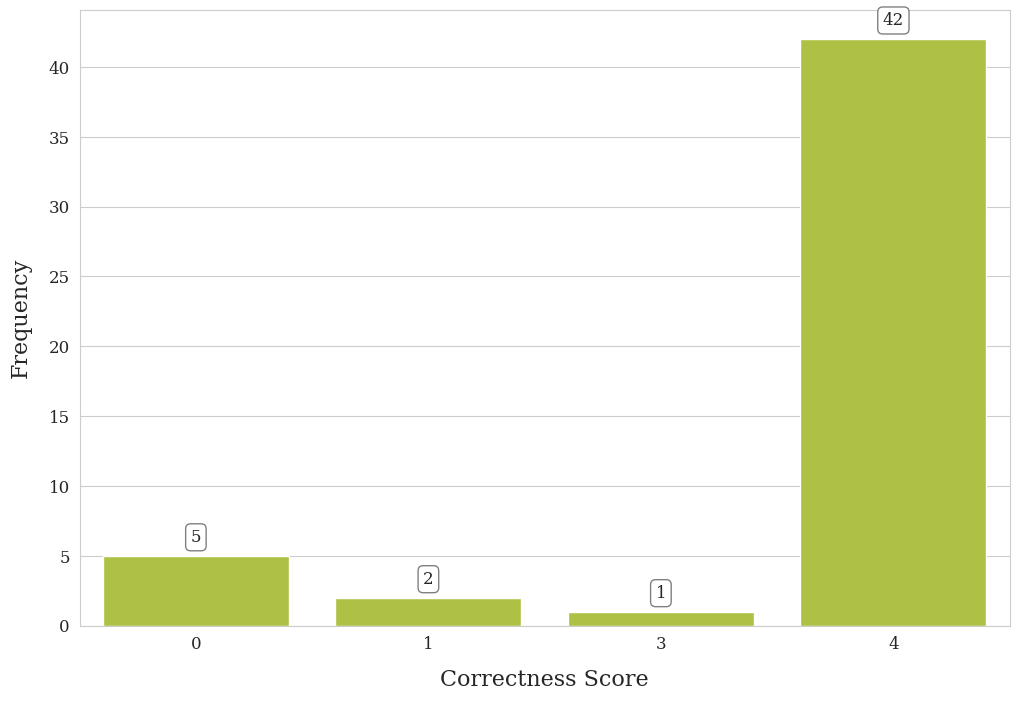

In [72]:
plt.figure(figsize=fig_size)
ax = sns.countplot(
    x="correctness_score",
    data=pipe_answers,
    order=sorted(pipe_answers["correctness_score"].unique()),
    color="#BED62F",
)

ax.set_xlabel("Correctness Score")
ax.set_ylabel("Frequency")
# ax.set_title("Total Frequency of Correctness Scores")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2, p.get_height() + 1),
        ha="center",
        bbox=bbox_props,
        fontsize=12,
    )

plt.show()

In [7]:
filtered_pipe_answers = pipe_answers[pipe_answers["correctness_score"] < 3]
filtered_pipe_answers.to_excel(pipe_eval_path + "/send_to_expert_pipe.xlsx")

for index, row in filtered_pipe_answers.iterrows():
    print(f"LLM Answer:         {row['answer']}")
    print(f"Ground Truth:       {row['ground_truth']}")
    print(f"Correctness Score:  {row['correctness_score']}")
    print()

LLM Answer:         Wenn Leuchten nicht erkannt werden, empfiehlt es sich, sie aus dem Netzwerk zu löschen und dann mit der 
Ground Truth:       Verwenden Sie die Hilfefunktion "Leuchten nicht gefunden?" in der App und folgen Sie den Anweisungen. Falls die Leuchten länger als 24 Stunden in Betrieb sind, müssen Sie diese manuell löschen, indem Sie fünfmal hintereinander für jeweils 5 Sekunden die Spannung von der Leuchte nehmen und sie dann erneut zum Netzwerk hinzufügen.
Correctness Score:  0

LLM Answer:         Interact Pro ist eine intelligente Beleuchtungslösung.
Ground Truth:       Interact Pro ist eine kosteneffiziente und kabellose vernetzte Beleuchtungslösung.
Correctness Score:  0

LLM Answer:         UV-C-Licht
Ground Truth:       hochintensives kurzwelliges UV-Licht
Correctness Score:  1

LLM Answer:         Interact Pro bietet Kunden mehrere Vorteile einschließlich einfacher Einstieg in vernetzte Beleuchtung, automatischer Lichtregelung, angepasster Lichtszenen für verschie

In [8]:
# Remove the questions that are send to the expert from both dataframes.
filtered_questions = filtered_pipe_answers["question"]

pipe_answers = pipe_answers[~pipe_answers["question"].isin(filtered_questions)]
bing_chat_answers = bing_chat_answers[
    ~bing_chat_answers["question"].isin(filtered_questions)
]

### Model comparision

In [82]:
pipe_scores = pipe_answers[metrics].mean()
bing_chat_scores = bing_chat_answers[metrics].mean()

# Create all scores dataframe for plotting.
df_all_scores = pd.DataFrame(
    {
        "Metrics": metrics * 2,
        "Scores": pipe_scores.tolist() + bing_chat_scores.tolist(),
        "Method": ["Application"] * len(pipe_scores)
        + ["Bing Chat"] * len(bing_chat_scores),
    }
)

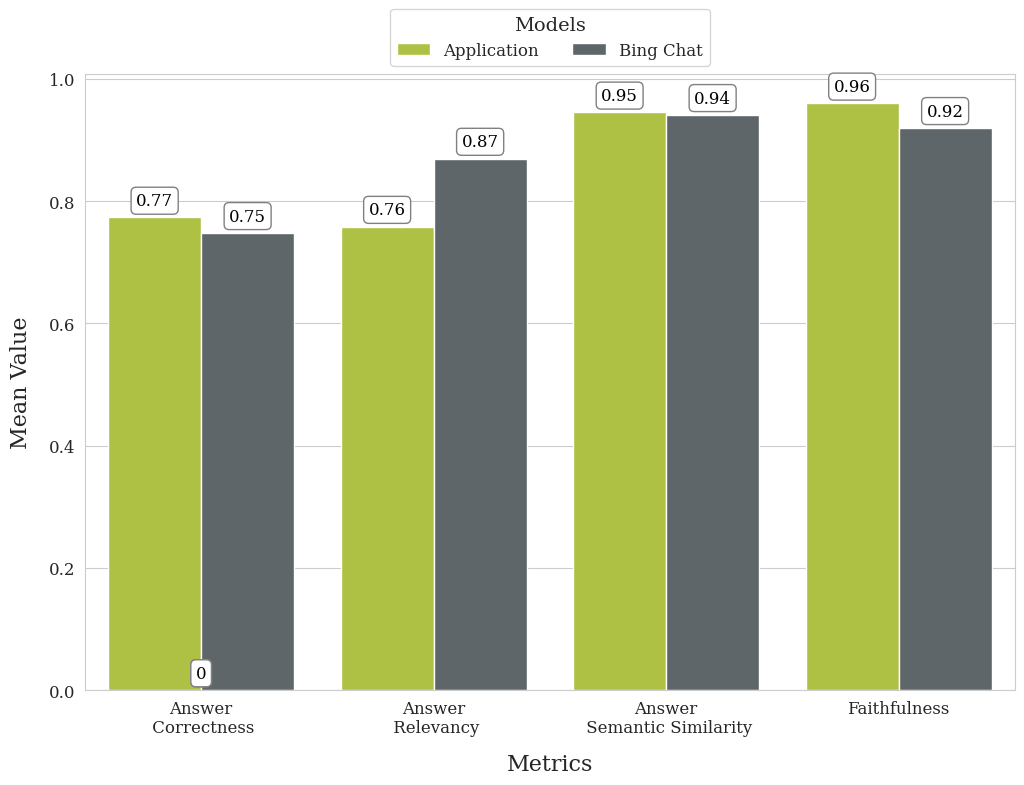

In [83]:
plt.figure(figsize=fig_size)
ax = sns.barplot(x="Metrics", y="Scores", hue="Method", data=df_all_scores)

sns.move_legend(
    ax,
    "lower center",
    bbox_to_anchor=(0.5, 1),
    ncol=3,
    title="Models",
    title_size=14,
    fontsize=12,
    frameon=True,
)

x_labels = [
    "Answer\n Correctness",
    "Answer\n Relevancy",
    "Answer\n Semantic Similarity",
    "Faithfulness",
]

plt.xticks(ticks=range(len(x_labels)), labels=x_labels, rotation=0)
plt.xlabel("Metrics")
plt.ylabel("Mean Value")

for i, bar in enumerate(plt.gca().patches):
    plt.gca().text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02,
        round(bar.get_height(), 2),
        ha="center",
        color="black",
        fontsize=12,
        bbox=bbox_props,
    )

plt.show()